<a href="https://colab.research.google.com/github/Supansapkb/bsc_dpdm22/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Projecct : Customer Segmentation Classification

- Context
An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4, and P5). After intensive market research, they’ve deduced that the behavior of the new market is similar to their existing market.
In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for a different segment of customers. This strategy has work e exceptionally well for them. They plan to use the same strategy for the new markets and have identified 2627 new potential customers.
- บริบท
บริษัทรถยนต์มีแผนที่จะเข้าสู่ตลาดใหม่ด้วยผลิตภัณฑ์ที่มีอยู่ (P1, P2, P3, P4 และ P5) หลังจากการวิจัยตลาดอย่างเข้มข้น พวกเขาสรุปได้ว่าพฤติกรรมของตลาดใหม่นั้นคล้ายคลึงกับตลาดที่มีอยู่เดิม
ในตลาดที่มีอยู่ ทีมขายได้จัดประเภทลูกค้าทั้งหมดออกเป็น 4 กลุ่ม (A, B, C, D ) จากนั้นจึงทำการเข้าถึงและสื่อสารแบบแบ่งส่วนสำหรับลูกค้ากลุ่มต่างๆ กลยุทธ์นี้ทำงานได้ดีเป็นพิเศษสำหรับพวกเขา พวกเขาวางแผนที่จะใช้กลยุทธ์เดียวกันสำหรับตลาดใหม่และได้ระบุผู้มีโอกาสเป็นลูกค้าใหม่ 2,627 ราย

Content

ID -- Unique ID

Gender -- Gender of the customer

Ever_Married -- Marital status of the customer

Age-- Age of the customer

Graduated -- Is the customer a graduate?

Profession -- Profession of the customer

Work_Experience -- Work Experience in years

Spending_Score -- Spending score of the customer

Family_Size -- Number of family members for the customer (including the customer)

Var_1 -- Anonymised Category for the customer

Segmentation -- (target) Customer Segment of the customer

In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import json
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

In [2]:
#เชื่อม google drive 
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
data_train = pd.read_csv('/content/drive/MyDrive/bsc_dpdm22/Train.csv', sep=',')
data_test = pd.read_csv('/content/drive/MyDrive/bsc_dpdm22/Test.csv', sep=',')
data_t = pd.concat([data_train, data_test])
data_t = data_t.drop('Var_1', axis=1)
data_t.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,A


In [13]:
#Checking dataset info by feature
data_t.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10695 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 919.1+ KB


<ipython-input-13-ab14ff12aacf>:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  data_t.info(verbose=True, null_counts=True)


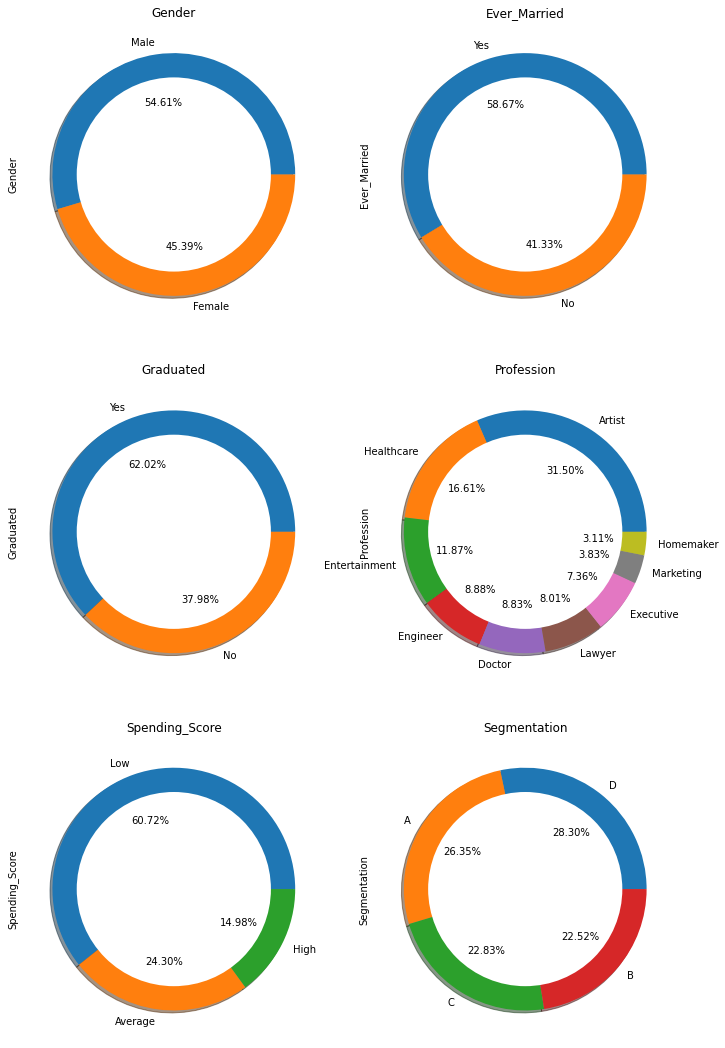

In [14]:
cat_vars = data_t.select_dtypes(include=['object']).columns

plt.figure(figsize=(10,20))

for i, var in enumerate(cat_vars):
    plt.subplot(4, 2, i+1)
    data_t[var].value_counts().plot(kind='pie',autopct='%.2f%%',shadow = True)
    centre_circle = plt.Circle((0,0),0.80,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title(var)


plt.tight_layout()
plt.show()

In [ ]:
#Checking the existence of duplicated rows
data_t.duplicated().sum()

38

# Data Cleaning

In [15]:
# 1. Remove duplicated rows (38 in total)
data_t.drop_duplicates(inplace=True)

# 2. Create a calculated column (Work_Experience_to_Age_Ratio) that could potentialy be a relevant feature to the model (to be tested later)
data_t["Work_Experience_to_Age_Ratio"] = data_t["Work_Experience"] / data_t["Age"]

# 3. Treat missing values:
#    *   3.1 Ever_Married: consider missing values as No
#    *   3.2 Graduated: consider missing values as No
#    *   3.3 Profession: delete (it´s not representative the amount of blanks)
#    *   3.4 Family_Size: mean
#    *   3.5 Var_1: delete (it´s not representative the amount of blanks)
#    *   3.6 Work_Experience: estimate based on Age
data_t["Ever_Married"].fillna("No", inplace=True)
data_t["Graduated"].fillna("No", inplace=True)
data_t.dropna(subset=["Profession"], inplace=True)
data_t["Family_Size"].fillna(data_t["Family_Size"].mean(), inplace=True)
data_t["Work_Experience"].replace(0, np.nan, inplace=True)
data_t["Work_Experience"].fillna(data_t["Work_Experience"].sum() / data_t["Age"].sum() * data_t["Age"], inplace=True)
data_t["Work_Experience_to_Age_Ratio"].replace(0, np.nan, inplace=True)
data_t["Work_Experience_to_Age_Ratio"].fillna(data_t["Work_Experience"] / data_t["Age"], inplace=True)

# 4. Remove column ID as it´s not important to the model
data_t.drop(["ID"], axis=1, inplace=True)

# 5. Convert categorical variables (Gender, Ever_Married, Graduated, Profession, Spending_Score, Var_1, Segmentation) to dummies
data_t = pd.concat([data_t, pd.get_dummies(data_t["Gender"], prefix="Gender")], axis=1)
data_t = pd.concat([data_t, pd.get_dummies(data_t["Ever_Married"], prefix="Ever_Married")], axis=1)
data_t = pd.concat([data_t, pd.get_dummies(data_t["Graduated"], prefix="Graduated")], axis=1)
data_t = pd.concat([data_t, pd.get_dummies(data_t["Profession"], prefix="Profession")], axis=1)
data_t["Spending_Score_Level"] = data_t["Spending_Score"].apply(lambda x: ["Low", "Average", "High"].index(x))+1 #Label encoding
#target variable for the ML model (label encoding)
data_t["Segmentation_Level"] = data_t["Segmentation"].apply(lambda x: ["A", "B", "C", "D"].index(x))+1 #Label encoding
#target variable for the DL model (one-hot encoding)
data_t = pd.concat([data_t, pd.get_dummies(data_t["Segmentation"], prefix="Segmentation")], axis=1)
Segmentation_encoding_dl = np.asarray(data_t[["Segmentation_A", "Segmentation_B", "Segmentation_C", "Segmentation_D"]])
#creating for the DL model the response variable through the concatenation of the created dummy columns, forming an array

# 6. Convert all numerical variables (Age, Work_Experience, Family_Size, Work_Experience_to_Age_Ratio) to categorical ranges (to be used in next step when analyzing correlations)
data_t["Age_Range"] = np.where(data_t.Age>=60, "60+", np.where(data_t.Age>=50, "50-60", np.where(data_t.Age>=40, "40-50", np.where(data_t.Age>=30, "30-40", np.where(data_t.Age>=18, "18-30", "18-")))))
data_t["Work_Experience_Range"] = np.where(data_t.Work_Experience>=10, "10+", np.where(data_t.Work_Experience>=5, "5-10", "0-5"))
data_t["Family_Size_Range"] = np.where(data_t.Family_Size>=6, "6+", np.where(data_t.Family_Size>=3, "3-6", "0-3"))
data_t["Work_Experience_to_Age_Ratio_Range"] = np.where(data_t.Work_Experience_to_Age_Ratio>=0.5, "0.5+", np.where(data_t.Work_Experience_to_Age_Ratio>=0.4,
                                                                                                                   "0.4-0.5", np.where(data_t.Work_Experience_to_Age_Ratio>=0.3,
                                                                                                                    "0.3-0.4", np.where(data_t.Work_Experience_to_Age_Ratio>=0.2,
                                                                                                                    "0.2-0.3", np.where(data_t.Work_Experience_to_Age_Ratio>=0.1,
                                                                                                                    "0.1-0.2", "0+")))))


In [ ]:
data_t.head(10)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,...,Var_1_Cat_7,Segmentation_Level,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D,Age_Range,Work_Experience_Range,Family_Size_Range,Work_Experience_to_Age_Ratio_Range
0,Male,No,22,No,Healthcare,1.000000,Low,4.0,Cat_4,D,...,0,4,0,0,0,1,18-30,0-5,3-6,0+
1,Female,Yes,38,Yes,Engineer,2.062542,Average,3.0,Cat_4,A,...,0,1,1,0,0,0,30-40,0-5,3-6,0+
2,Female,Yes,67,Yes,Engineer,1.000000,Low,1.0,Cat_6,B,...,0,2,0,1,0,0,60+,0-5,0-3,0+
3,Male,Yes,67,Yes,Lawyer,3.636586,High,2.0,Cat_6,B,...,0,2,0,1,0,0,60+,0-5,0-3,0+
4,Female,Yes,40,Yes,Entertainment,2.171096,High,6.0,Cat_6,A,...,0,1,1,0,0,0,40-50,0-5,6+,0+
5,Male,Yes,56,No,Artist,3.039535,Average,2.0,Cat_6,C,...,0,3,0,0,1,0,50-60,0-5,0-3,0+
6,Male,No,32,Yes,Healthcare,1.000000,Low,3.0,Cat_6,C,...,0,3,0,0,1,0,30-40,0-5,3-6,0+
7,Female,No,33,Yes,Healthcare,1.000000,Low,3.0,Cat_6,D,...,0,4,0,0,0,1,30-40,0-5,3-6,0+
8,Female,Yes,61,Yes,Engineer,3.310922,Low,3.0,Cat_7,D,...,1,4,0,0,0,1,60+,0-5,3-6,0+
9,Female,Yes,55,Yes,Artist,1.000000,Average,4.0,Cat_6,C,...,0,3,0,0,1,0,50-60,0-5,3-6,0+


## Data Modelling

In [16]:
#Defining Xs and y

X = data_t[["Age", "Family_Size", "Profession_Healthcare", "Profession_Entertainment", "Profession_Artist",
             "Ever_Married_Yes", "Graduated_No", "Spending_Score_Level"]]
y = data_t["Segmentation_Level"]
y_dl = Segmentation_encoding_dl #for the DL model

#Scaling all features

from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler()
X_scaled = sc_X.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

#Setting train/test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0)
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_scaled, y_dl, random_state=0) #for the DL model


##Clssification

## Descition tree

Train: Accuracy:0.689, Precision:0.698, Recall:0.689, F1:0.689
Test : Accuracy:0.417, Precision:0.424, Recall:0.417, F1:0.419
ROC AUC (train): 0.923
ROC AUC (test): 0.621

Confusion matrix:
Predicted    1    2    3    4
Actual                       
1          321  156  115  122
2          181  176  152   81
3          136  139  249   74
4          204  105   64  349, 



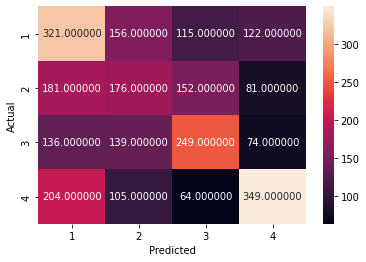

In [34]:
#Creating a Descition tree model and checking its Metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import seaborn as sns

# Fitting to the model
model_dt = DecisionTreeClassifier().fit(X_train, y_train)

# Getting the predictions and metrics
y_preds_train = model_dt.predict(X_train)
y_preds_test = model_dt.predict(X_test)
accuracy_train = accuracy_score(y_train, y_preds_train)
accuracy_test = accuracy_score(y_test, y_preds_test)
precision_train = precision_score(y_train, y_preds_train, average="weighted")
precision_test = precision_score(y_test, y_preds_test, average="weighted")
recall_train = recall_score(y_train, y_preds_train, average="weighted")
recall_test = recall_score(y_test, y_preds_test, average="weighted")
f1_train = f1_score(y_train, y_preds_train, average="weighted")
f1_test = f1_score(y_test, y_preds_test, average="weighted")

# Getting predicted probabilities and ROC AUC score
y_pred_proba_train = model_dt.predict_proba(X_train)
y_pred_proba_test = model_dt.predict_proba(X_test)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train, multi_class='ovr')
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test, multi_class='ovr')

# Printing the metrics and overall model performance
print("Train: Accuracy:{0:,.3f}, Precision:{1:,.3f}, Recall:{2:,.3f}, F1:{3:,.3f}".format(accuracy_train, precision_train, recall_train, f1_train))
print("Test : Accuracy:{0:,.3f}, Precision:{1:,.3f}, Recall:{2:,.3f}, F1:{3:,.3f}".format(accuracy_test, precision_test, recall_test, f1_test))
print("ROC AUC (train): {:.3f}".format(roc_auc_train))
print("ROC AUC (test): {:.3f}".format(roc_auc_test))

# Confusion Matrix
print("\nConfusion matrix:")
confusion_matrix = pd.crosstab(y_test, y_preds_test, rownames=["Actual"], colnames=["Predicted"])
print(f"{confusion_matrix}, \n")
sns.heatmap(confusion_matrix, annot=True, fmt='0f')

# Visualizing y_pred in the dataset
y_preds_all = model_dt.predict(X_scaled)
data_t["Segmentation_Level_predicted"] = y_preds_all


## Naive Beyes

Train: Accuracy:0.447, Precision:0.432, Recall:0.447, F1:0.426
Test : Accuracy:0.444, Precision:0.432, Recall:0.444, F1:0.427
ROC AUC (train): 0.707
ROC AUC (test): 0.697

Confusion matrix:
Predicted    1   2    3    4
Actual                      
1          260  96  203  155
2          155  98  240   97
3          110  47  357   84
4          133  50   89  450, 



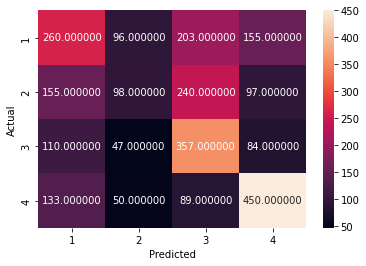

In [31]:
#Creating a Naive Bayes model and checking its Metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import seaborn as sns

# Fitting to the model
model_nb = GaussianNB().fit(X_train, y_train)

# Getting the predictions and metrics
y_preds_train = model_nb.predict(X_train)
y_preds_test = model_nb.predict(X_test)
accuracy_train = accuracy_score(y_train, y_preds_train)
accuracy_test = accuracy_score(y_test, y_preds_test)
precision_train = precision_score(y_train, y_preds_train, average="weighted")
precision_test = precision_score(y_test, y_preds_test, average="weighted")
recall_train = recall_score(y_train, y_preds_train, average="weighted")
recall_test = recall_score(y_test, y_preds_test, average="weighted")
f1_train = f1_score(y_train, y_preds_train, average="weighted")
f1_test = f1_score(y_test, y_preds_test, average="weighted")

# Getting predicted probabilities and ROC AUC score
y_pred_proba_train = model_nb.predict_proba(X_train)
y_pred_proba_test = model_nb.predict_proba(X_test)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train, multi_class='ovr')
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test, multi_class='ovr')

# Printing the metrics and overall model performance
print("Train: Accuracy:{0:,.3f}, Precision:{1:,.3f}, Recall:{2:,.3f}, F1:{3:,.3f}".format(accuracy_train, precision_train, recall_train, f1_train))
print("Test : Accuracy:{0:,.3f}, Precision:{1:,.3f}, Recall:{2:,.3f}, F1:{3:,.3f}".format(accuracy_test, precision_test, recall_test, f1_test))
print("ROC AUC (train): {:.3f}".format(roc_auc_train))
print("ROC AUC (test): {:.3f}".format(roc_auc_test))

# Confusion Matrix
print("\nConfusion matrix:")
confusion_matrix = pd.crosstab(y_test, y_preds_test, rownames=["Actual"], colnames=["Predicted"])
print(f"{confusion_matrix}, \n")
sns.heatmap(confusion_matrix, annot=True, fmt='0f')

# Visualizing y_pred in the dataset
y_preds_all = model_nb.predict(X_scaled)
data_t["Segmentation_Level_predicted"] = y_preds_all


## K-Nearest Neighbors

Train: Accuracy:0.564, Precision:0.572, Recall:0.564, F1:0.565
Test : Accuracy:0.432, Precision:0.440, Recall:0.432, F1:0.433
ROC AUC (train): 0.820
ROC AUC (test): 0.667

Confusion matrix:
Predicted    1    2    3    4
Actual                       
1          342  143   96  133
2          197  187  123   83
3          152  159  224   63
4          203   91   47  381, 



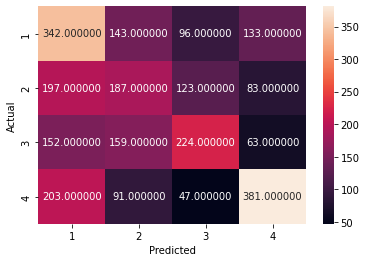

In [35]:
#Creating a K-Nearest Neighbors model and checking its Metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import seaborn as sns

# Fitting to the model
model_knn = KNeighborsClassifier().fit(X_train, y_train)

# Getting the predictions and metrics
y_preds_train = model_knn.predict(X_train)
y_preds_test = model_knn.predict(X_test)
accuracy_train = accuracy_score(y_train, y_preds_train)
accuracy_test = accuracy_score(y_test, y_preds_test)
precision_train = precision_score(y_train, y_preds_train, average="weighted")
precision_test = precision_score(y_test, y_preds_test, average="weighted")
recall_train = recall_score(y_train, y_preds_train, average="weighted")
recall_test = recall_score(y_test, y_preds_test, average="weighted")
f1_train = f1_score(y_train, y_preds_train, average="weighted")
f1_test = f1_score(y_test, y_preds_test, average="weighted")

# Getting predicted probabilities and ROC AUC score
y_pred_proba_train = model_knn.predict_proba(X_train)
y_pred_proba_test = model_knn.predict_proba(X_test)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train, multi_class='ovr')
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test, multi_class='ovr')

# Printing the metrics and overall model performance
print("Train: Accuracy:{0:,.3f}, Precision:{1:,.3f}, Recall:{2:,.3f}, F1:{3:,.3f}".format(accuracy_train, precision_train, recall_train, f1_train))
print("Test : Accuracy:{0:,.3f}, Precision:{1:,.3f}, Recall:{2:,.3f}, F1:{3:,.3f}".format(accuracy_test, precision_test, recall_test, f1_test))
print("ROC AUC (train): {:.3f}".format(roc_auc_train))
print("ROC AUC (test): {:.3f}".format(roc_auc_test))

# Confusion Matrix
print("\nConfusion matrix:")
confusion_matrix = pd.crosstab(y_test, y_preds_test, rownames=["Actual"], colnames=["Predicted"])
print(f"{confusion_matrix}, \n")
sns.heatmap(confusion_matrix, annot=True, fmt='0f')

# Visualizing y_pred in the dataset
y_preds_all = model_knn.predict(X_scaled)
data_t["Segmentation_Level_predicted"] = y_preds_all

## Deciding on a model

- descition tree
ROC AUC (train): 0.923 |
ROC AUC (test): 0.621 

- Naive beyes
ROC AUC (train): 0.707  |
ROC AUC (test): 0.697

- KNN
ROC AUC (train): 0.820  |
ROC AUC (test): 0.667

จากผลการทดสอบของ Decision Tree, Naive Bayes, และ KNN โดยใช้การประเมินผลด้วย ROC AUC บนชุดข้อมูล train และ test พบว่า Decision Tree มีค่า ROC AUC สูงที่สุดบนชุดข้อมูล train คือ 0.923 แต่มีค่า ROC AUC ต่ำกว่าชุดข้อมูล test ที่ 0.621 ซึ่งเป็นสัญญาณว่าโมเดลอาจเกิดปัญหา overfitting จึงไม่เหมาะสมสำหรับการใช้งานจริง

ส่วน Naive Bayes และ KNN ค่า ROC AUC บนชุดข้อมูล train และ test ไม่ต่างกันมากนัก แต่ ROC AUC ของ Naive Bayes บนชุดข้อมูล test สูงกว่า KNN นั่นหมายความว่า Naive Bayes อาจเหมาะสมกว่าในการใช้งานจริง

ดังนั้น จึงควรเลือกใช้โมเดล Naive Bayes สำหรับการทำนาย Segment ของลูกค้า

## K - Means Clustering

- The K-Means model should be constructed using only the training data, as the purpose of the model is to learn patterns and structure in the data that it has not seen before. Using the test data or combining the test and train data may result in overfitting and a model that does not generalize well to new, unseen data. Therefore, it is important to use the training data to fit the model and then evaluate its performance using the test data.
- แบบจำลอง K-Means ควรสร้างขึ้นโดยใช้ข้อมูลการฝึกอบรมเท่านั้น เนื่องจากจุดประสงค์ของแบบจำลองคือการเรียนรู้รูปแบบและโครงสร้างในข้อมูลที่ไม่เคยเห็นมาก่อน การใช้ข้อมูลทดสอบหรือการรวมข้อมูลการทดสอบและการฝึกอบรมอาจส่งผลให้เกิดการ overfitting และโมเดลที่ไม่ครอบคลุมข้อมูลใหม่ที่มองไม่เห็น ดังนั้นจึงเป็นสิ่งสำคัญที่จะใช้ข้อมูลการฝึกอบรมให้เหมาะสมกับแบบจำลอง จากนั้นจึงประเมินประสิทธิภาพโดยใช้ข้อมูลการทดสอบ

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [ ]:
#data 
data_train.head(10)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,D
1,462643,Female,Yes,38,Yes,Engineer,0.0,Average,3.0,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,B
4,462669,Female,Yes,40,Yes,Entertainment,0.0,High,6.0,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,C


## Data Cleaning

In [ ]:
# fill NA with Text 
data_train['Graduated'] = data_train['Graduated'].fillna('Unknown')  #จบการศึกษาfillnaว่าunknown 
data_train['Ever_Married'] = data_train['Ever_Married'].fillna('Unknown') #สถานภาพการสมรส
data_train['Profession'] = data_train['Profession'].fillna('Unknown') #อาชีพ
# fill NA with 0,1
data_train[['Work_Experience']]  = data_train[['Work_Experience']].fillna(0) #ประสบการณ์การทำงาน
data_train[['Family_Size']]  = data_train[['Family_Size']].fillna(1) #อย่างน้อยก็ต้องอยู่คนเดียว

In [ ]:
data_train.isnull().any()

ID                 False
Gender             False
Ever_Married       False
Age                False
Graduated          False
Profession         False
Work_Experience    False
Spending_Score     False
Family_Size        False
Segmentation       False
dtype: bool

In [ ]:
# How many is in each category
if 'cnt_IDS' not in data_train.columns:
    cd = data_train.groupby(['Segmentation'])['ID'].count().reset_index()
    cd['cnt_IDS'] = cd['ID']
    del cd['ID']
    df_train = data_train.merge(cd, on='Segmentation', how='left')

In [ ]:
# Drop the 'Segmentation' column from the data
df_train_kmeans = data_train.drop(['Segmentation', 'ID'], axis=1)

In [ ]:
df_train_kmeans.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,Female,Yes,38,Yes,Engineer,0.0,Average,3.0
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,Female,Yes,40,Yes,Entertainment,0.0,High,6.0


In [ ]:
# Convert the categorical columns to Label encoded columns
from sklearn.preprocessing import  LabelEncoder
encoder = LabelEncoder()
df_train_kmeans['Gender'] = encoder.fit_transform(df_train_kmeans['Gender'])
df_train_kmeans['Ever_Married'] = encoder.fit_transform(df_train_kmeans['Ever_Married'])
df_train_kmeans['Graduated'] = encoder.fit_transform(df_train_kmeans['Graduated'])
df_train_kmeans['Profession'] = encoder.fit_transform(df_train_kmeans['Profession'])
df_train_kmeans['Spending_Score'] = encoder.fit_transform(df_train_kmeans['Spending_Score'])


In [ ]:
# Impute missing values with the mean
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_train_kmeans_imputed = imputer.fit_transform(df_train_kmeans)

# Scale the data using the StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train_kmeans_imputed = scaler.fit_transform(df_train_kmeans_imputed)

In [ ]:
# To delete the warning message
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Elbow method to find the best number of clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_train_kmeans_imputed)
    Sum_of_squared_distances.append(km.inertia_)
    print("For k =", k, ", the inertia is", km.inertia_)  

For k = 1 , the inertia is 64544.000000000015
For k = 2 , the inertia is 50011.8450097319
For k = 3 , the inertia is 44630.00711901233
For k = 4 , the inertia is 38921.589790683924
For k = 5 , the inertia is 35488.22799555698
For k = 6 , the inertia is 33089.152418942365
For k = 7 , the inertia is 30848.72385413097
For k = 8 , the inertia is 29195.658245001614
For k = 9 , the inertia is 27550.932246694014
For k = 10 , the inertia is 26570.023712182076
For k = 11 , the inertia is 25061.0415405991
For k = 12 , the inertia is 24223.09637176994
For k = 13 , the inertia is 23435.775211587068
For k = 14 , the inertia is 22339.976096504633


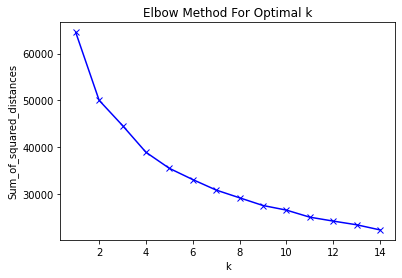

In [ ]:
# Plot the Elbow method
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
#Determine the best number of clusters using the elbow method
best_k = 4

#Train the KMeans model using the best number of clusters
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(df_train_kmeans_imputed)

KMeans(n_clusters=4)

In [ ]:
# Predict the cluster labels
labels = kmeans.predict(df_train_kmeans_imputed)

# Count the number of customers in each cluster
from collections import Counter
counts = Counter(labels)

# Get the target categories 'A', 'B', 'C', and 'D' in the 'Segmentation' column
target_categories = df_train['Segmentation']

# Find the target category that is most frequent in each cluster
cluster_categories = {}
for label, count in counts.items():
    cluster_data = target_categories[labels == label]
    most_frequent_category = cluster_data.value_counts().idxmax()
    cluster_categories[label] = most_frequent_category

# Map the predicted labels to target categories
mapped_labels = [cluster_categories[label] for label in labels]

# Append a column 'n_Clusters' to the dataframe with the mapped labels
df_train['new_Segmentation'] = mapped_labels


df_train

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation,cnt_IDS,new_Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,D,2268,D
1,462643,Female,Yes,38,Yes,Engineer,0.0,Average,3.0,A,1972,C
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,B,1858,A
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,B,1858,A
4,462669,Female,Yes,40,Yes,Entertainment,0.0,High,6.0,A,1972,C
...,...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,Unknown,0.0,Low,7.0,D,2268,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,D,2268,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,D,2268,A
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,B,1858,D


In [ ]:
# Calculate the number of correct predictions
correct_predictions = sum(df_train['Segmentation'] == df_train['new_Segmentation'])

# Calculate the total number of predictions
total_predictions = df_train.shape[0]

# Calculate the accuracy as a percentage
accuracy = (correct_predictions / total_predictions) * 100
print("Accuracy for K-Means: {:.2f}%".format(accuracy))

Accuracy for K-Means: 45.03%
